In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

chunk_size = 100000  # Adjust based on your memory constraints
data_iterator = pd.read_csv('D:/Downloads/final-year-project/data/preprocessed_train_data.csv', chunksize=chunk_size)

# Load the Transformer model
transformer_model = tf.keras.models.load_model('models/Transformer_ADAM')

# Placeholder for balanced data
balanced_data_chunks = []

for chunk in data_iterator:
    # Filter the data for primary_use==0 & meter==0 if required
    # chunk = chunk.query('primary_use==0 & meter==0')

    # Identify non-numeric columns to exclude (e.g., datetime columns)
    non_numeric_columns = ['timestamp']  # Replace with actual column names if different
    expected_feature_count = 12  # Model expects 12 features per time step
    all_feature_columns = [col for col in chunk.columns if col not in non_numeric_columns and col != 'meter_reading' and col != 'Unnamed: 0']

    # Subsample the data to balance the feature contributions
    # Example: Downsample the majority class `square_feet`
    data_majority = chunk[chunk['square_feet'] <= chunk['square_feet'].median()]
    data_minority = chunk[chunk['square_feet'] > chunk['square_feet'].median()]

    # Downsample majority class
    data_majority_downsampled = resample(data_majority,
                                         replace=False,    # sample without replacement
                                         n_samples=len(data_minority),     # to match minority class
                                         random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    balanced_chunk = pd.concat([data_majority_downsampled, data_minority])

    balanced_data_chunks.append(balanced_chunk)

# Combine all balanced chunks
data_balanced = pd.concat(balanced_data_chunks, ignore_index=True)

# Prepare data for model input (excluding non-numeric columns)
feature_columns = all_feature_columns[:expected_feature_count]

X = data_balanced[feature_columns].values.astype(np.float32)
y = data_balanced['meter_reading'].values.astype(np.float32)  # Meter Reading

# Handle NaN values in both X and y
# Remove rows with NaN values in X or y
non_nan_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
X = X[non_nan_indices]
y = y[non_nan_indices]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (5968120, 12)
Shape of y: (5968120,)


In [3]:
# Define a function to preprocess data into time series format
def create_time_series_data(X, y, time_steps=6):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare time series data
time_steps = 6
X_series, y_series = create_time_series_data(X, y, time_steps)

print("Shape of X_series:", X_series.shape)
print("Shape of y_series:", y_series.shape)


Shape of X_series: (5968114, 6, 12)
Shape of y_series: (5968114,)


In [4]:
import shap

# Select a larger subset of the data for SHAP explanation
sample_size = 100
X_sample = X_series[:sample_size]  # Shape (sample_size, time_steps, expected_feature_count)

print("Shape of X_sample:", X_sample.shape)

# Create a function to make predictions with the Transformer model
def model_predict(data):
    # Reshape data to (batch_size, time_steps, features)
    data_reshaped = data.reshape((-1, time_steps, expected_feature_count))
    print("Shape of data in model_predict:", data_reshaped.shape)
    return transformer_model.predict(data_reshaped).flatten()

# Create SHAP explainer for the Transformer model using KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_sample.reshape(sample_size, -1))

print("Explainer prepared")


Shape of X_sample: (100, 6, 12)
Shape of data in model_predict: (100, 6, 12)
4/4 [==============================] - 1s 26ms/step
Explainer prepared


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 36ms/step
Shape of data in model_predict: (216400, 6, 12)
6763/6763 [==============================] - 200s 30ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 18ms/step
Shape of data in model_predict: (216400, 6, 12)
6763/6763 [==============================] - 199s 29ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 18ms/step
Shape of data in model_predict: (216400, 6, 12)
6763/6763 [==============================] - 207s 31ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 18ms/step
Shape of data in model_predict: (216400, 6, 12)
6763/6763 [==============================] - 194s 29ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 17ms/step
Shape of data in model_predict: (216400, 6, 12)
6763/6763 [==============================] - 

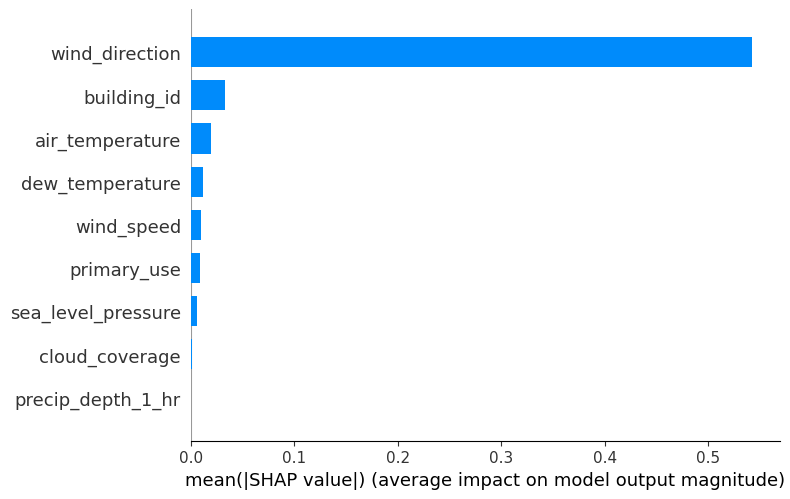

In [5]:
import matplotlib.pyplot as plt

# Generate SHAP values for the selected instances
shap_values = explainer.shap_values(X_sample.reshape(sample_size, -1))

print("Shape of SHAP values:", np.array(shap_values).shape)

# Reshape SHAP values to original time-series format
shap_values_reshaped = np.array(shap_values).reshape(sample_size, time_steps, expected_feature_count)

print("Shape of reshaped SHAP values:", shap_values_reshaped.shape)

# Mean of Absolute Values across time steps
shap_values_mean_abs = np.mean(np.abs(shap_values_reshaped), axis=1)

# Aggregate the mean absolute SHAP values across all instances
shap_values_mean_abs_aggregated = np.mean(shap_values_mean_abs, axis=0)

print("Shape of aggregated SHAP values:", shap_values_mean_abs_aggregated.shape)

# Create a DataFrame to display SHAP values
shap_values_df = pd.DataFrame(shap_values_mean_abs_aggregated, index=feature_columns, columns=['Mean Absolute SHAP Value'])

# Remove the 'square_feet' and 'building_id' features from the DataFrame
shap_values_df = shap_values_df.drop(['square_feet', 'site_id', 'meter'], errors='ignore')
# shap_values_df = shap_values_df.drop(['square_feet', 'building_id', 'precip_depth_1_hr'], errors='ignore')

# Print the SHAP values DataFrame
print(shap_values_df)

# Plot SHAP summary with original feature names
shap.summary_plot(shap_values_df['Mean Absolute SHAP Value'].values.reshape(1, -1), feature_names=shap_values_df.index, plot_type="bar")
# plt.title("SHAP Summary Plot (Mean of Absolute Values)")
# plt.show()


### Save the SHAP XAI Explainer

In [6]:
from joblib import dump
dump(explainer, 'mean_explainer.joblib') 


['mean_explainer.joblib']

### Try to Load the SHAP Explainer

In [7]:
from joblib import load

# Load the saved explainer
explainer = load('mean_explainer.joblib')

### SHAP XAI Final Plot

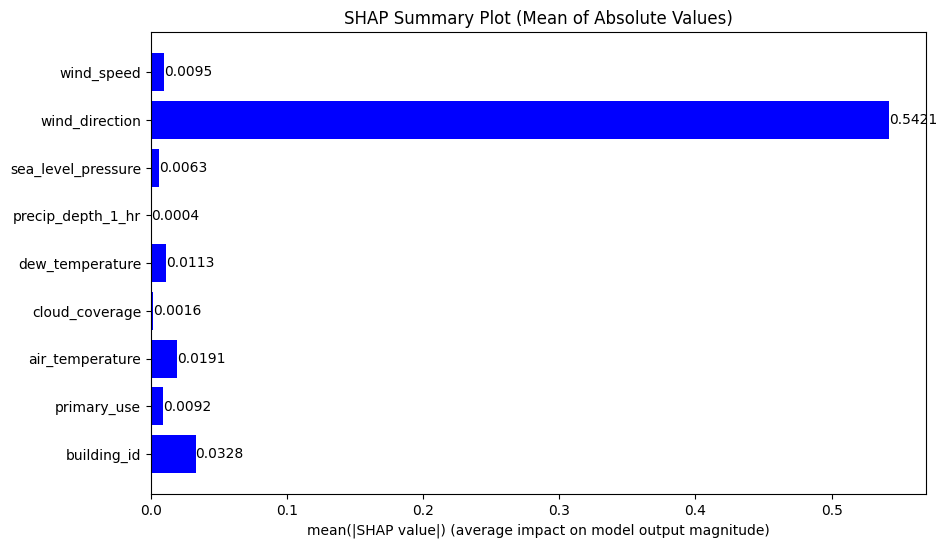

In [9]:
import matplotlib.pyplot as plt

# Get the SHAP values and feature names
shap_values = shap_values_df['Mean Absolute SHAP Value'].values
shap_values_df = shap_values_df.drop(['square_feet', 'site_id', 'meter'], errors='ignore')
feature_names = shap_values_df.index

# Plot the SHAP summary with values displayed
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, shap_values, color="blue")
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('SHAP Summary Plot (Mean of Absolute Values)')

# Annotate bars with values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.4f}', va='center')

plt.show()